In [3]:
!unzip sunspots.zip

Archive:  sunspots.zip
  inflating: Sunspots.csv            


In [4]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('Sunspots.csv', index_col=0)
df = df.rename(columns={"Date": "date", "Monthly Mean Total Sunspot Number": "spots"})
df.head()

,date,spots
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7


In [0]:
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')


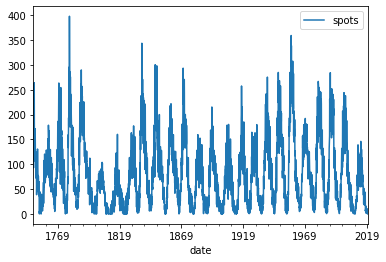

In [6]:
df.plot()

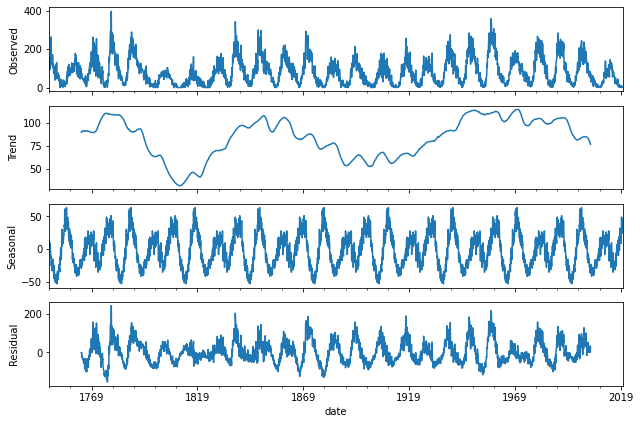

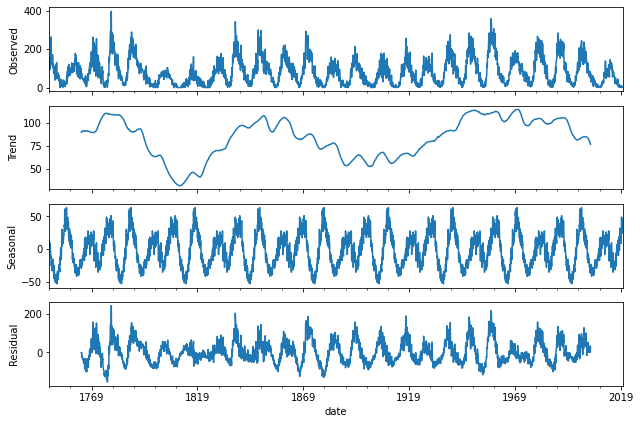

In [19]:
import statsmodels.api as sm
import matplotlib
decomposition = sm.tsa.seasonal_decompose(df, model = 'additive', freq=365)
matplotlib.rcParams['figure.figsize'] = [9, 6.0]
decomposition.plot()


In [24]:
import tensorflow as tf
import pandas as pd
import numpy as np

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

data = pd.read_csv('Sunspots.csv')
series = data['Monthly Mean Total Sunspot Number'].to_numpy()
time = data['Unnamed: 0'].to_numpy()
split_time = int(len(time)*0.66)
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]


window_size = 30
batch_size = 32
shuffle_buffer_size = 1000
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size=60, batch_size=200, shuffle_buffer=shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
         
          tf.keras.layers.LSTM(60, return_sequences=True, input_shape=[None, 1]),
          tf.keras.layers.LSTM(60, return_sequences=True),
          tf.keras.layers.Dense(30, activation="relu"),
          tf.keras.layers.Dense(10, activation="relu"),
          tf.keras.layers.Dense(1),
          tf.keras.layers.Lambda(lambda x: x * 400) 
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model.summary()


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2146,)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 60)          14880     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 60)          29040     
_________________________________________________________________
dense (Dense)                (None, None, 30)          1830      
_________________________________________________________________
dense_1 (Dense)              (None, None, 10)          310       
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           11        
_________________________________________________________________
lambda (Lambda)              (None, None, 1)           0         
Total params: 46,071

In [0]:
history = model.fit(train_set,epochs=250)


In [22]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]
tf.keras.metrics.mean_squared_error(x_valid, rnn_forecast).numpy()

586.9932

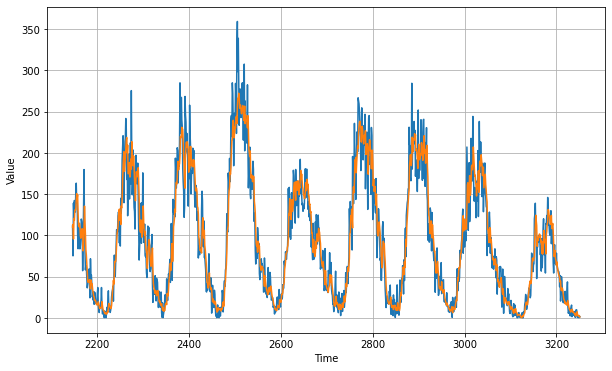

In [23]:
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

predicted=105.534552, expected=112.100000
predicted=107.246697, expected=75.300000
predicted=88.500018, expected=139.200000
predicted=119.917690, expected=122.400000
predicted=118.089734, expected=142.400000
predicted=128.630236, expected=134.300000
predicted=130.644754, expected=128.300000
predicted=125.985576, expected=152.400000
predicted=144.315743, expected=163.400000
predicted=151.895354, expected=139.600000
predicted=142.860535, expected=149.600000
predicted=147.696833, expected=102.300000
predicted=122.111836, expected=83.900000
predicted=106.352766, expected=98.300000
predicted=108.618970, expected=114.800000
predicted=112.110896, expected=104.700000
predicted=106.974992, expected=83.800000
predicted=92.200249, expected=87.900000
predicted=91.557245, expected=97.000000
predicted=96.210522, expected=119.900000
predicted=109.465673, expected=117.100000
predicted=110.480770, expected=109.600000
predicted=107.318670, expected=57.300000
predicted=79.693507, expected=90.100000
predi

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=8.031503, expected=27.900000
predicted=21.055181, expected=13.800000
predicted=15.214242, expected=22.400000
predicted=19.440413, expected=16.100000
predicted=17.091360, expected=0.600000
predicted=6.968211, expected=18.100000
predicted=16.640897, expected=9.900000
predicted=11.265243, expected=5.100000
predicted=7.976296, expected=40.100000
predicted=27.775757, expected=15.400000
predicted=15.900535, expected=5.800000
predicted=11.045989, expected=9.800000
predicted=12.453516, expected=3.400000
predicted=7.110084, expected=17.400000
predicted=15.233755, expected=46.000000
predicted=31.450598, expected=39.100000
predicted=31.049565, expected=18.800000
predicted=22.356769, expected=38.200000
predicted=33.588651, expected=47.900000
predicted=41.065311, expected=42.200000
predicted=40.350034, expected=63.400000
predicted=53.588196, expected=48.800000
predicted=47.373611, expected=29.100000
predicted=37.266164, expected=70.500000
predicted=60.218910, expected=45.400000
predicted=

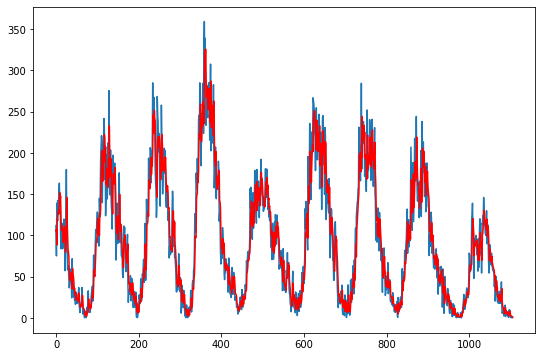

In [18]:


from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error


X = df.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

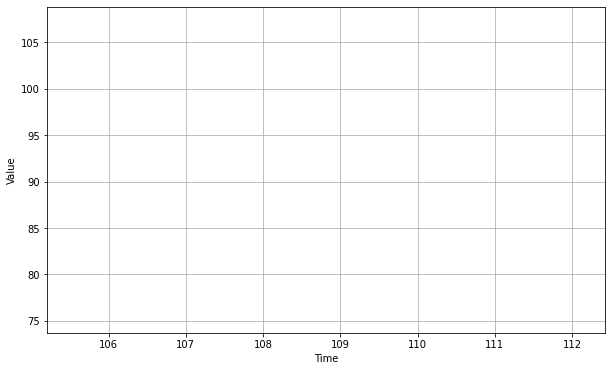